# Part 3: User Profile Analysis

In this notebook, we want to demonstrate several things with the user profiles which we have created. Therefore the main dataset, which we will work on within this notebook is the result of the last notebook. When necessary, other data frames will be used for additional information. 

We start by visualizing correlations of the information within the user profiles. Then, we use the information to predict the gender of the users and their university education. Later, we cluster users by their reviews and create a GIF of the movements of a specific user in the end.

**Table of contents**

1. [Vizualisations of user profiles](#Vizualisations)
2. [Predicting Gender](#Gender)\
  2.1 [Logisitc Regression](#logres)\
  2.2 [Random Forest](#ranfor)
3. [Predicting University education](#University)
4. [User reviews clusters](#Clusters)
5. [GIF for user movement movie](#GIF)

**General code**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn.tree import plot_tree
from sklearn import tree
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import seaborn as sns

import holoviews as hv
from holoviews import opts
hv.extension('bokeh')

import bokeh

import warnings
warnings.filterwarnings('ignore')


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#!pip install holoviews

In [ ]:
df_users = pd.read_csv("/content/drive/MyDrive/ABAProject/User_profiles_Final.csv")

<a id='Vizualisations'></a>
## 1 Vizualisations of user profiles

First, we show an interactive correlation matrix of the most important features. Although it seems very big in the beginning, it is easy to read due to the hover tool. Further, it makes sense to keep most of the features in as we want to make predictions and dive into the correlations even deeper later on in the notebook.

The color settings are adjusted for colorblind people so that everybody can read this correlation matrix. For a visually more appealing heatmap, we made a suggestion on which other "cmap" can be used.

In [ ]:
# For the code to run reliably, it is safer to do the imports in the same cell
import holoviews as hv
from holoviews import opts
hv.extension('bokeh')

import bokeh

#Correlation among numerical features
mov=df_users.copy()

#scale numerical features
features_to_scale = ['mean_rating', 'min_rating', 'mean_review_length (characters)', 'max_review_length (characters)',
       'mean_readability', 'mean_profanity', 'number_reviewed_places', 'mean_price', 'max_price', 'rating']

scaler = MinMaxScaler()
for feature in features_to_scale: 
    mov[feature]=mov[feature].astype('float')
    mov[feature] = scaler.fit_transform(mov[[feature]])
    
# dropping unnessary columns
movie=mov.drop(columns=['userID', 'gender', 'top_sentiment','mean_emotion_sum', 'mean_positive_emotions', 'mean_negative_emotions', 'interest', 'top_category', 'top_category_highlevel', 'max_price', 'rating', 'max_review_length (characters)', 'min_rating'])

# creating the correlation matrix
corrmat = movie.corr()

# creating a interactive heatmap
heatmap = hv.HeatMap((corrmat.columns, corrmat.columns, 
                      corrmat.values), vdims=['Correlation'])

heatmap.opts(opts.HeatMap(tools=['hover'], colorbar=True, width=325, toolbar=None, clim=(-0.3, 1), frame_width=400, frame_height=400, xrotation=90))

heatmap.opts(cmap='colorblind') # 'plasma' is more appealing. Other colors can be found here: http://holoviews.org/user_guide/Style_Mapping.html

**Findings** 

The first thing which is noticeable in the heatmap is, that there are no strong correlations. Apart from that, we can see, that anger has a weak correlation with fear, sadness, and disgust which intuitively makes sense since negative emotions often come together. It is also no surprise that the mean rating has a weak positive correlation with joy & trust and a weak negative correlation with sadness, disgust, fear, and anger. Furthermore, there seems to be a moderate negative correlation between the mean rating and the mean profanity. That means that more negative reviews tend to have more swear words. 

Let's visualize this last aspect in a different way!

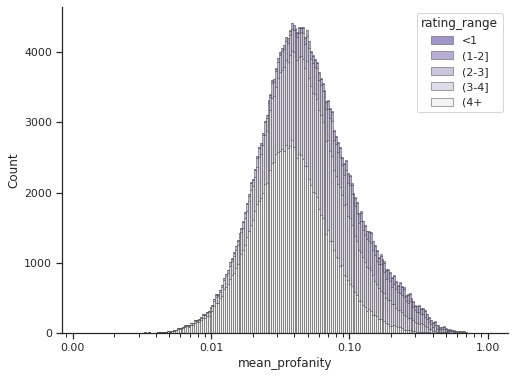

In [ ]:
diamonds = df_users.copy()

bins = [0, 1, 2, 3, 4, np.inf]
names = ['<1', '(1-2]', '(2-3]', '(3-4]', '(4+']

diamonds['rating_range'] = pd.cut(diamonds['mean_rating'], bins, labels=names)

sns.set_theme(style="ticks")

f, ax = plt.subplots(figsize=(8, 6))
sns.despine(f)

sns.histplot(
    diamonds,
    x="mean_profanity", hue="rating_range",
    multiple="stack",
    palette="light:m_r",
    edgecolor=".3",
    linewidth=.5,
    log_scale=True,
)
ax.xaxis.set_major_formatter(mpl.ticker.ScalarFormatter())

# Source: https://seaborn.pydata.org/examples/histogram_stacked.html

**Findings**

It can be seen, that this distribution is not symmetric gaussian. A Gaussian distribution would imply, that rating and mean profanity do not correlate (in other words: even if a review has a certain level of profanity, this does not influence the distribution of the rating). What we see, however, is that the distribution is skewed to the right and that the layers showing the lower rating tend to be more to the right. This clearly shows that the higher the profanity, the lower the ratings tend to be.

<a id='Gender'></a>
## 2 Predicting Gender

In the following, the emotions values which were obtained earlier will be used to predict the gender of the users. To do so, two different models, namely **Logistic Regression** as well as **Random Forest Classification** will be used.

As the dataset is imbalanced between men and women, we start by downsampling the male dataset. The goal is to find out if there is a correlation between emotionality and gender and if so, which feelings and sentiments are the most important.

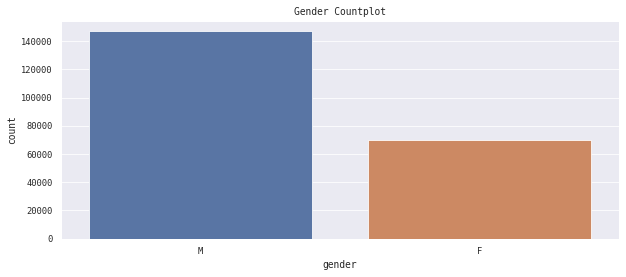

In [ ]:
# visualize the number of male and female users in the user profiles
fig, ax = plt.subplots(figsize=(10,4))
sns.countplot(df_users['gender'], ax=ax)
plt.title('Gender Countplot')
plt.show()

In [ ]:
#downsampling
males = df_users[df_users["gender"] == 'M']
females = df_users[df_users["gender"] == 'F']

#sampling down the males and adding them to the size of the female dataset
downsampled = males.sample(len(females)).append(females) 

In [ ]:
#encoding the gender column
downsampled['gender_encoded'] = downsampled['gender'].apply(lambda x: 1 if x == 'M' else 0) 

In [ ]:
feature_names = ['mean_fear', 'mean_anger', 'mean_anticipation', 'mean_trust',
       'mean_surprise', 'mean_sadness', 'mean_disgust', 'mean_joy',
              'mean_review_length (characters)', 'mean_profanity']

x = downsampled[feature_names]

y = downsampled['gender_encoded']

In [ ]:
rs = 42
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size = 0.7, stratify = y, random_state = rs)

#standardize
x_train = (x_train-x_train.mean())/x_train.std()
x_test = (x_test-x_test.mean())/x_test.std()

<a id='logres'></a>
### 2.1 Logistic Regression

In [ ]:
LogReg=LogisticRegression()
LogReg.fit(x_train, y_train)

LogisticRegression()

In [ ]:
score=LogReg.score(x_test, y_test)
print(score)

print(LogReg.coef_)
for cname, val in zip(x_train.columns, LogReg.coef_.tolist()[0]):
    print("%s=%.3f"%(cname, val))

0.5776804728064509
[[ 0.00902197  0.06869384 -0.03469247  0.07295066  0.05352864 -0.05084283
  -0.05848361 -0.33571614 -0.2382056  -0.00682174]]
mean_fear=0.009
mean_anger=0.069
mean_anticipation=-0.035
mean_trust=0.073
mean_surprise=0.054
mean_sadness=-0.051
mean_disgust=-0.058
mean_joy=-0.336
mean_review_length (characters)=-0.238
mean_profanity=-0.007


In [ ]:
ypred_lr = LogReg.predict(x_test)

In [ ]:
print(classification_report(y_test, ypred_lr))

              precision    recall  f1-score   support

           0       0.58      0.58      0.58     20897
           1       0.58      0.58      0.58     20896

    accuracy                           0.58     41793
   macro avg       0.58      0.58      0.58     41793
weighted avg       0.58      0.58      0.58     41793



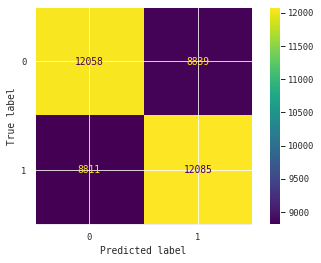

In [ ]:
cm = confusion_matrix(y_test, ypred_lr, labels=LogReg.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=LogReg.classes_)
disp.plot()
plt.show()

**Findings** 

With Logistic Regression, an **accuracy of 0.58** and an **F1-score of 0.58** were achieved. The variables with the biggest weights are "mean_joy" and length of the reviews while most of the coefficients have small values.  

With binary classification, the minimum requirement is to be better than random guessing, so to have a score higher than 50 %. We see, that our model is barely performing better than random guessing which is not a satisfying result.

Now we will investigate if a Random Forest Regressor is better at predicting the gender!

<a id='ranfor'></a>
### 2.2 Random Forest

In [ ]:
rf = RandomForestClassifier(random_state = 42)
#fitting the model
rf.fit(x_train, y_train)
#making a prediction
ypred_rf = rf.predict(x_test)

In [ ]:
print(classification_report(y_test, ypred_rf))

              precision    recall  f1-score   support

           0       0.57      0.58      0.58     20897
           1       0.57      0.57      0.57     20896

    accuracy                           0.57     41793
   macro avg       0.57      0.57      0.57     41793
weighted avg       0.57      0.57      0.57     41793



The perfomance of the classifier decreased a bit. We try now to find the optimal values for the Random Forest.

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in range(10,110,10)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
#Whether bootstrap or not
bootstrap = [True, False]

# Create the random grid
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

The base model is not run again as we saved the parameters of the improved model.

In [ ]:
# Use the random grid to search for best hyperparameters
# Creating the base model to tune
#rf2 = RandomForestClassifier(random_state = 42)
 
# Searching across 100 different combinations, and using all available scores
#rf_random = RandomizedSearchCV(estimator = rf2, param_distributions = param_grid, n_iter = 10, cv=3, verbose=5, random_state=42, n_jobs = -1)
# Fit the random search model
#rf_random.fit(x_train, y_train)

In [ ]:
#print the best parameters as found by the RandomizedSearchCV

best_params = {'n_estimators': 2000,
 'min_samples_split': 10,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 10,
 'bootstrap': True}

print("The best parameters from the randomized search are: ")
for key, items in best_params.items():
    print(key, ":", items)

#to get the estimators for plotting the tree, we need to make a dedicated model (it has the same performance as rf_random)
rf_improved = RandomForestClassifier(**best_params, random_state = 42)
rf_improved.fit(x_train, y_train)

#Code taken from https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74

The best parameters from the randomized search are: 
n_estimators : 2000
min_samples_split : 10
min_samples_leaf : 2
max_features : sqrt
max_depth : 10
bootstrap : True


RandomForestClassifier(max_depth=10, max_features='sqrt', min_samples_leaf=2,
                       min_samples_split=10, n_estimators=2000,
                       random_state=42)

In [ ]:
#making a prediction and printing the classification report
y_pred_improved = rf_improved.predict(x_test)
print(classification_report(y_test, y_pred_improved))

              precision    recall  f1-score   support

           0       0.59      0.56      0.58     20897
           1       0.58      0.61      0.60     20896

    accuracy                           0.59     41793
   macro avg       0.59      0.59      0.59     41793
weighted avg       0.59      0.59      0.59     41793



**Findings**

It was possible to lift the accuracy and the F1-score a bit to ~0.59 which is an improvement of 0.01. Even with a more sophisticated machine learning model, **usable predictions were not achieved**. 

The reasons for this are manifold; in the notebook before, we already described the flaws of the emotionality values and the gender column. The fact that both, the emotions and the gender, have their flaws, makes it harder to derive information from one to the other. 

To investigate in detail, we will plot now the male and female variables to understand why it is not possible to build a strong classifier.



Text(0, 0.5, 'Counts')

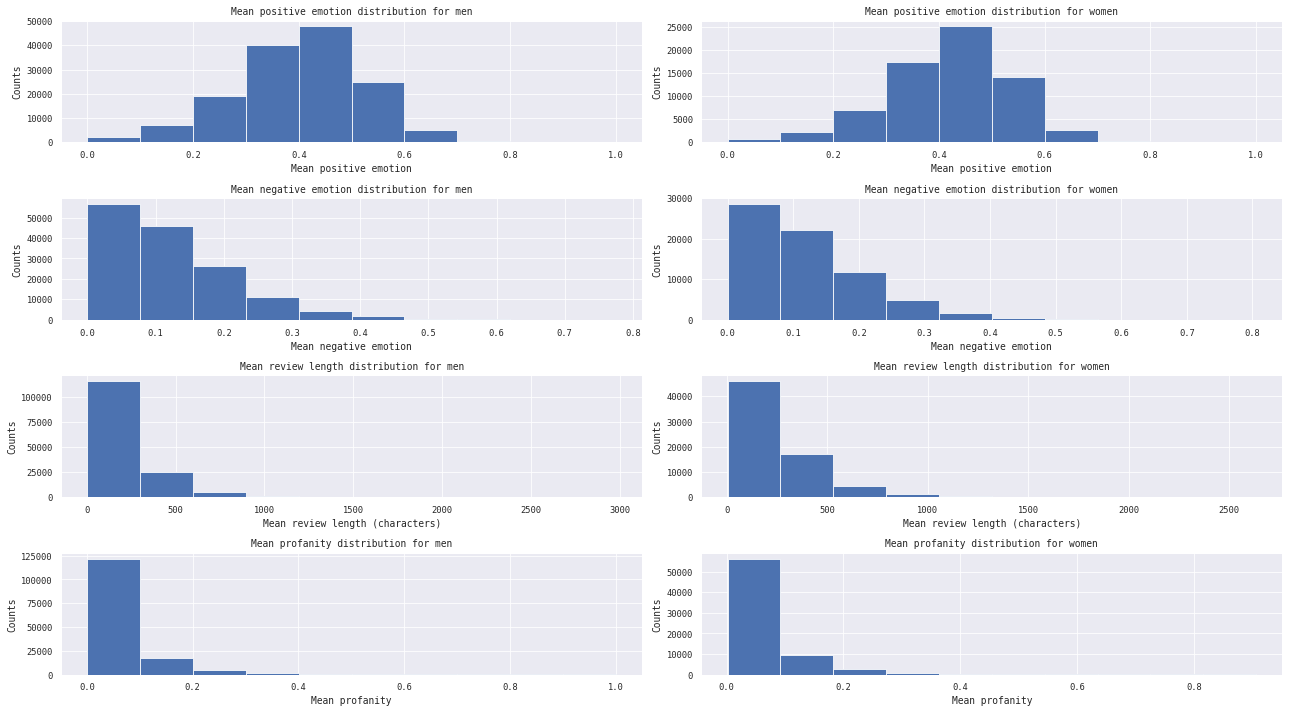

In [ ]:
n_bins=10
histi=df_users.copy()
fig, ax = plt.subplots(4, 2, sharey=False, tight_layout=True,figsize=(18,10))

ax[0,0].hist(histi[histi['gender'] == 'M']['mean_positive_emotions'], bins=n_bins)
ax[0,0].set_title("Mean positive emotion distribution for men")
ax[0,0].set_xlabel("Mean positive emotion")
ax[0,0].set_ylabel("Counts")
ax[0,1].hist(histi[histi['gender'] == 'F']['mean_positive_emotions'], bins=n_bins)
ax[0,1].set_title("Mean positive emotion distribution for women")
ax[0,1].set_xlabel("Mean positive emotion")
ax[0,1].set_ylabel("Counts")

ax[1,0].hist(histi[histi['gender'] == 'M']['mean_negative_emotions'], bins=n_bins)
ax[1,0].set_title("Mean negative emotion distribution for men")
ax[1,0].set_xlabel("Mean negative emotion")
ax[1,0].set_ylabel("Counts")
ax[1,1].hist(histi[histi['gender'] == 'F']['mean_negative_emotions'], bins=n_bins)
ax[1,1].set_title("Mean negative emotion distribution for women")
ax[1,1].set_xlabel("Mean negative emotion")
ax[1,1].set_ylabel("Counts")

ax[2,0].hist(histi[histi['gender'] == 'M']["mean_review_length (characters)"], bins=n_bins)
ax[2,0].set_title("Mean review length distribution for men")
ax[2,0].set_xlabel("Mean review length (characters)")
ax[2,0].set_ylabel("Counts")
ax[2,1].hist(histi[histi['gender'] == 'F']['mean_review_length (characters)'], bins=n_bins)
ax[2,1].set_title("Mean review length distribution for women")
ax[2,1].set_xlabel("Mean review length (characters)")
ax[2,1].set_ylabel("Counts")

ax[3,0].hist(histi[histi['gender'] == 'M']["mean_profanity"], bins=n_bins)
ax[3,0].set_title("Mean profanity distribution for men")
ax[3,0].set_xlabel("Mean profanity")
ax[3,0].set_ylabel("Counts")
ax[3,1].hist(histi[histi['gender'] == 'F']['mean_profanity'], bins=n_bins)
ax[3,1].set_title("Mean profanity distribution for women")
ax[3,1].set_xlabel("Mean profanity")
ax[3,1].set_ylabel("Counts")

**Findings** 

As shown previously, people tend to give positive reviews rather than negative ones. We also see that the distribution for the mean positive and mean negative emotions (which represent all the emotions used in the classifier and were used to reduce the number of plots needed) and also all other variables like profanity and review length have very similar distributions. 

Our final conclusion is, therefore, that we **can not sharply distinguish between males and females by using their reviews**. The different distributions are just too similar for the two genders, thus, nothing remarkable can be observed in comparing them.

This can also be seen when visualizing the random forest below: the Gini coefficient is only improving slightly when the tree is splitting, meaning that the tree hardly knows how to distinguish between gender.

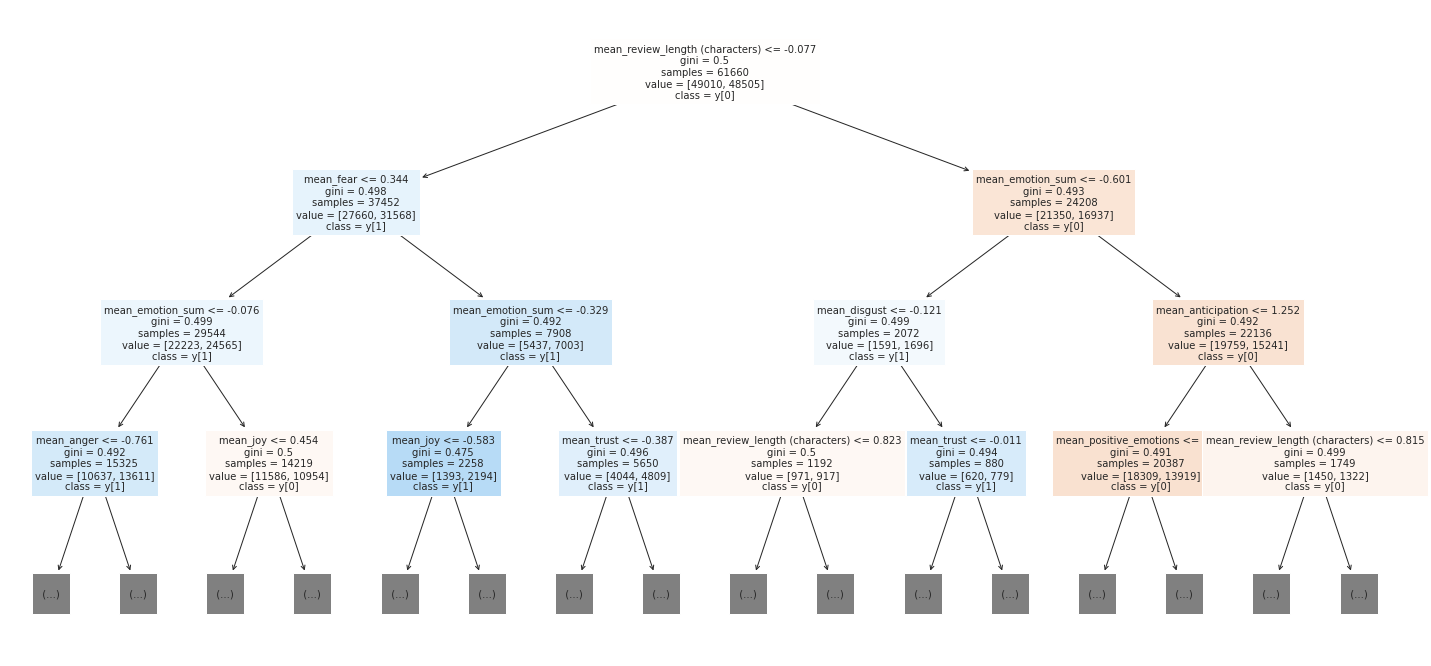

In [ ]:
fig = plt.figure(figsize=(25,12))
treeplot = tree.plot_tree(rf.estimators_[0], max_depth =3, feature_names=x.columns, class_names=True, filled=True, fontsize = 10)

<a id='University'></a>
## 3 Predicting of University education

In this section, we try to predict University education using the three variables "profanity", "readability" and "review length". 

First, the whole dataset is analyzed. Using all of the data, it is assumed that the users that did not specify information about their education, do not have higher education (meaning that the column "University" = 0). 

Even with this assumption, we see a **difference in the mean readability between the two groups** as can be seen below.

In [ ]:
print("The mean readability for people who didnt went to college is: %.2f" % df_users[df_users["university_education"] == "0"]["mean_readability"].mean())
print("The mean readability for people who went to college is: %.2f" %df_users[df_users["university_education"] == "1"]["mean_readability"].mean())

The mean readability for people who didnt went to college is: 6.19
The mean readability for people who went to college is: 6.46


Additionally, **people who went to college also write less profane reviews**:

In [ ]:
print("The mean profanity value for people who didnt went to college is: %.2f" % df_users[df_users["university_education"] == "0"]["mean_profanity"].mean())
print("The mean profanity value for people who went to college is: %.2f" %df_users[df_users["university_education"] == "1"]["mean_profanity"].mean())

The mean profanity value for people who didnt went to college is: 0.07
The mean profanity value for people who went to college is: 0.05


However, it **does not seems like more educated users write significantly longer reviews**:

In [ ]:
print("The mean profanity value for people who didnt went to college is: %.2f" % df_users[df_users["university_education"] == "0"]['mean_review_length (characters)'].mean())
print("The mean profanity value for people who went to college is: %.2f" %df_users[df_users["university_education"] == "1"]['mean_review_length (characters)'].mean())

The mean profanity value for people who didnt went to college is: 228.75
The mean profanity value for people who went to college is: 234.36


With this initial overview, we now wish to build a classifier. Since the dataset is unbalanced, we start the prediction by sampling down.

In [ ]:
ones = df_users[df_users["university_education"] =="1"]
zeros = df_users[df_users["university_education"] =="0"]

downsampled_u1 = zeros.sample(len(ones)).append(ones)

In [ ]:
downsampled_u1 = downsampled_u1[["university_education", "mean_review_length (characters)", "mean_readability", "mean_profanity"]]
downsampled_u1 = downsampled_u1.dropna()

In [ ]:
y = downsampled_u1.university_education
y = y.astype('int')
X = downsampled_u1[["mean_review_length (characters)", "mean_readability", "mean_profanity"]]

from sklearn.model_selection import train_test_split
train_X, test_X, train_y, test_y = train_test_split(X, y, train_size=0.7, shuffle=True, random_state=1)

train_X_standard=(train_X-train_X.mean())/train_X.std()
test_X_standard=(test_X-test_X.mean())/test_X.std()

from sklearn.linear_model import LogisticRegression
LogReg_u1=LogisticRegression() 
LogReg_u1.fit(train_X_standard, train_y)

ypred_u1 = LogReg_u1.predict(test_X_standard)
print(classification_report(test_y, ypred_u1))

              precision    recall  f1-score   support

           0       0.58      0.42      0.49     10122
           1       0.54      0.69      0.60      9816

    accuracy                           0.55     19938
   macro avg       0.56      0.56      0.55     19938
weighted avg       0.56      0.55      0.55     19938



In [ ]:
for cname, val in zip(train_X.columns, LogReg_u1.coef_.tolist()[0]):
    print("%s=%.5f"%(cname, val))

mean_review_length (characters)=-0.01783
mean_readability=0.11393
mean_profanity=-0.26329


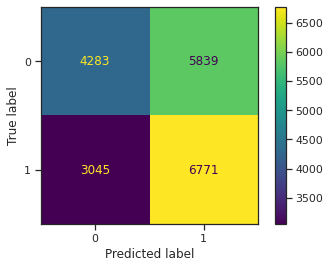

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(test_y, ypred_u1, labels=LogReg_u1.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=LogReg_u1.classes_)
disp.plot()
plt.show()

**Findings**

With this approach, a **56 % accuracy and an average F1-score of 0.56** can be achieved. It can be seen, that profanity is the most important predictor followed by readability. As we could have already seen from the initial overview is the message length no strong predictor. Again, our scores are quite low and barely better than a coin flip. We, therefore, try to improve the prediction by excluding people who didn't fill in the column "education" in the original data frame. To sort those out, the original data frame will be imported.

In [ ]:
users = pd.read_csv("/content/drive/MyDrive/ABAProject/Users.csv")

In [ ]:
users = users.rename(columns={"Unnamed: 0":"userID"})
df_test = pd.merge(df_users, users,on="userID")

In [ ]:
# excluding users, which have empty education columns
df_test = df_test[(df_test["education"] != "[[[], [], [], [], [], 6], []]") & (df_test["education"] !="[[], []]") &(df_test["education"] !=0)]

In [ ]:
# excluding everbody whose education is unknown
df_test = df_test[df_test["university_education"] != "Unknown"]

With this subset of users, we try again to make the prediction.

In [ ]:
ones = df_test[df_test["university_education"] =="1"]
zeros = df_test[df_test["university_education"] =="0"]

downsampled_u2 = ones.sample(len(zeros)).append(zeros)

In [ ]:
downsampled_u2 = downsampled_u2[["university_education", "mean_review_length (characters)", "mean_readability", "mean_profanity"]]
downsampled_u2 = downsampled_u2.dropna()

In [ ]:
y = downsampled_u2.university_education
y = y.astype('int')
X = downsampled_u2[["mean_review_length (characters)", "mean_readability", "mean_profanity"]]

from sklearn.model_selection import train_test_split
train_X, test_X, train_y, test_y = train_test_split(X, y, train_size=0.7, shuffle=True, random_state=1)

train_X_standard=(train_X-train_X.mean())/train_X.std()
test_X_standard=(test_X-test_X.mean())/test_X.std()

from sklearn.linear_model import LogisticRegression
LogReg_u2=LogisticRegression() 
LogReg_u2.fit(train_X_standard, train_y)

ypred_u2 = LogReg_u2.predict(test_X_standard)
print(classification_report(test_y, ypred_u2))

              precision    recall  f1-score   support

           0       0.57      0.53      0.55      7939
           1       0.57      0.61      0.59      8066

    accuracy                           0.57     16005
   macro avg       0.57      0.57      0.57     16005
weighted avg       0.57      0.57      0.57     16005



In [ ]:
for cname, val in zip(train_X.columns, LogReg_u2.coef_.tolist()[0]):
    print("%s=%.5f"%(cname, val))

mean_review_length (characters)=0.06650
mean_readability=0.16980
mean_profanity=-0.22564


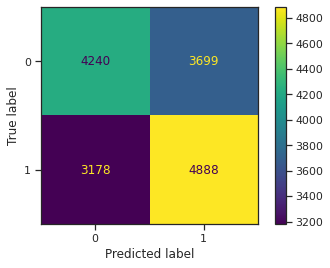

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(test_y, ypred_u2, labels=LogReg_u2.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=LogReg_u2.classes_)
disp.plot()
plt.show()

The values improved slightly with an **accuracy and F1-score of around 0.57**. The importance of the variables didn't change. Even though we are only including people who wrote something in the "education" column, the classifier performs barely better than the base model. An explanation for this is for example, that a lot of people which were labeled with "0" (meaning, they didn't go to college) went to college but they used abbreviations for their universities that are not included in our algorithm. Therefore, a better result might be obtained if a list with all abbreviations of American universities was included in the list. Still, another problem is that some people made mistakes in their entries (in the code below it can be seen, that the person wrote college with 3 "l").

In [ ]:
df_test[df_test["education"] == "[[[], [], [], [], [], 6], [['Art Center Colllege of Design', '', [[1, 1, 2007], [1, 1, 2011]], '', '']]]"]["education"].iloc[0]

"[[[], [], [], [], [], 6], [['Art Center Colllege of Design', '', [[1, 1, 2007], [1, 1, 2011]], '', '']]]"

Additionally, we found out that the "readability" score can be high, because (and not despite!) people make spelling mistakes. To fix this flaw, one would need to detect all the mistakenly high scores and exclude them. This is another burden for the prediction. If one would nevertheless would like to draw a conclusion, then it had to be that there are no major differences in the way people with a degree and those who don't write their reviews at Google.

From both prediction attempts (gender and education), we have to conclude that it is hard to create models which are performing substantially better than the 50 % baseline. We described different flaws in our methods and libraries and one central issue is, that we use already flawed variables (like the emotions which were obtained or the university status) for the prediction.

<a id='Clusters'></a>
## 4 User reviews clusters

**User’s reviews cluster with DBSCAN**

This part gets the geographic clusters in which a user has been. This task is achieved using the [DBSCAN](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html) algorithm.

This data gives an insight into where users live or have been for a long period of time. By setting a parameter of min_reviews for clusters it is possible to discard those single reviews that maybe are due to a road trip, for example, whereas the location at the cluster area indicates that the user stayed there for some time.

The purpose of this task is to obtain the exact locations in which each of the users has been. Each review is associated with an establishment (or place), this establishment might have information about the state or city in which is located, if it does, it would be easy to compute the clusters by this state or city.

In contrast to the state/city discrete data, and in case of more precision or lack of state/city variable for the location, this algorithm can identify clusters based on the latitude and longitude of the reviews.

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/ABAProject/Clean_dataset_google_local_data_with_3+_reviews.csv')

In [ ]:
def get_users_with_minimum_reviews(df, min_reviews=8, n_samples=None):
    """
    Returns a new df with n_samples users and their reviews with a minimum reviews.
    If n_samples is None then all users with min_reviews are taken.
    """

    df_count = df.groupby(by="userID").size().reset_index(name="count").sort_values(by="count", ascending=False)
    df_count = df_count[df_count["count"] >= min_reviews]

    if n_samples is not None:
        df_count = df_count.sample(min(n_samples, len(df_count)))

    top_users = list(df_count["userID"])
    new_df = df[df["userID"].isin(top_users)]
    print(f"{len(top_users)} users with >= {min_reviews} reviews. Total: {len(new_df)} reviews")

    return new_df

def generate_random_colors(n_colors):
    """
    Genrate random n_colors, used for the different users.
    """
    rand_colors = []
    for j in range(n_colors):
        rand_color = ["#"+''.join([random.choice('ABCDEF0123456789') for i in range(6)])]
        rand_colors.append(rand_color[0])
    return rand_colors

# Reducing the dataframe to users with at least those reviews
df = get_users_with_minimum_reviews(df, 23)


6902 users with >= 23 reviews. Total: 335443 reviews


In [ ]:
import folium
from sklearn.cluster import DBSCAN
from sklearn.metrics.pairwise import haversine_distances
from math import radians
import random

def convert_to_radians(point):
    """
    Converts point [lat, long] to radians.
    Also can be a single number (lat or long) to radians
    """
    if type(point) == list:
        return [radians(point[0]), radians(point[1])]
    return radians(point)

def get_users_clusters(df_reviews):
    
    """
    Gets a df with the user reviews and a column that indicates the cluster PER USER. 
    -1 means no cluster or outlier.
    """
    df_reviews = df_reviews.copy()
    
    distinct_users = list(df_reviews["userID"].unique()) # Hope that it is ordered so can be added to df easily
    distance_matrices = [] # One distance matrix per user
    users_clusters = [] # List of clusters one by one

    df_reviews["user_clusters"] = -1

    # DBSCAN needs a precomputed distance matrix since no usual distances are possible (earth is not flat)
    clustering = DBSCAN(eps=30, min_samples=2, metric="precomputed")

    for idx, user in enumerate(distinct_users):
        print(f"Getting clusters from user {idx+1} of {len(distinct_users )}", end="\r")
        # Get user points
        user_points = [point for point in df_reviews[df_reviews["userID"] == user]["point"]]
        
        # get distance matrix
        distance_matrix = haversine_distances(user_points)
        distance_matrix = distance_matrix * 6371000/1000 # Kilometers
        distance_matrices.append(distance_matrix)

        # Training the model with this user's distances
        clustering.fit(distance_matrix)

        # Setting this user's clusters
        mask = df_reviews["userID"] == user
        df_reviews.loc[mask, "user_clusters"] = clustering.labels_

    return df_reviews

# Converting the latitude and longitude to radians
df["point"] = df.apply(lambda row: [radians(row["lat"]), radians(row["long"])], axis=1)
df_c = get_users_clusters(df[df["userID"] == '111424166638019627542'])

In [ ]:
# Functions to get the clusters mean location and plotting them
def get_clusters_mean(df_user):
    """
    Pass a df with JUST one user and their reviews.
    """
    different_clusters = list(df_user["user_clusters"].unique())
    cluster_means = []
    for cluster in different_clusters:
        if cluster == -1:
            continue        
    
        points_lats = df_user[df_user["user_clusters"] == cluster]["lat"]
        points_longs = df_user[df_user["user_clusters"] == cluster]["long"]  
        
        mean_lats = points_lats.mean()
        mean_longs = points_longs.mean()
        
        cluster_means.append([mean_lats, mean_longs])
        
    return cluster_means

def plot_reviews_clusters(df):
    """
    Plots in folium the reviews and clusters for each user in df
    """

    user_list = list(df["userID"].unique())
    # Generate random colors for them
    rand_colors = generate_random_colors(len(user_list))

    m = folium.Map(location=[40.654710, -103.057716], zoom_start=4)
    
    for idx, user in enumerate(user_list):
        # Get reviews for only that user
        user_reviews = df[df["userID"] == user]

        # Creating a layer for each user
        user_group = folium.FeatureGroup(name=idx).add_to(m)

        user_reviews.apply(lambda row: 
                            user_group.add_child(folium.CircleMarker(
                                [row.lat, row.long],
                                tooltip=row.userID,
                                # color="black",
                                color=rand_colors[idx],
                                fill=True,
                                radius=5
                                         )),
                            axis=1
                           )
        
        # Now plot the clusters
        cluster_means = get_clusters_mean(user_reviews)
        for cluster in cluster_means:
            user_group.add_child(
                folium.Marker(cluster, tooltip=f"Cluster for user {user}")
            )
            
        print(cluster_means)
    folium.LayerControl().add_to(m)
    return m

In [ ]:
plot_reviews_clusters(df_c)

[[43.52501407142857, -96.72685085714288], [29.715310900000002, -98.1307934], [44.97834629411765, -93.1647242352941], [39.67820088888889, -104.9197876111111], [29.530672, -98.4833445], [28.3886775, -81.56793325000001], [38.887499000000005, -104.86282800000001]]


**Findings**

The resulting map above is shown the reviews and the clusters for just one user. In this case, a cluster has been marked where 2 or more reviews closed together are placed.

Each circle is a single review and each marker is a cluster. The markers point to potentially long-stays locations of the user, i.e, one of those markers is probably the place in which the user lives or has lived, and the other markers are probably vacation places.

<a id='GIF'></a>
## 5 GIF for user movement movie
This part creates a gif that displays the user's movement over time based on his/her reviews. When can do this without having explicit GPS information on the user him/herself. However, we do have the coordinates of all the places he/she reviewed on Google and can therefore make concrete assumptions about the travel habits of the person. This shall once more demonstrate, how much information about the users can be obtained by analyzing their Google reviews.

[Link to video](https://youtu.be/r5DzTSK4UIs)

![](https://drive.google.com/uc?export=view&id=1M4SXdzsQA1j4zGt20yDcrkPpu4JZDqHa)

In [ ]:
# Do not execute this code since it needs to create several images into a directory
import plotly.graph_objects as go


df = pd.read_csv("data/Clean_dataset_google_local_data_with_3+_reviews.csv")[["placeID", "lat", "long", "userID", "time", "rating"]]\

# Ordering by time
df = df.sort_values(by=["userID", "time"], ascending=True)

# Improved version, more efficient
def get_frame_and_previous(df,fig, frame_number):
    
    """
    Given a dataframe for a user, plots the points and their previous reviews for the movie.
    """

     # Adding the previous ones in different colours
    if frame_number > 0:
        df_frames = df[:frame_number]
        lats = df_frames["lat"]
        longs = df_frames["long"]

        fig.add_trace(go.Scattermapbox(
            lat=lats,
            lon=longs,
            mode='markers',
            marker=go.scattermapbox.Marker(
                size=10,
                color='rgb(255, 0, 0)',
                opacity=0.7
            ),
            hoverinfo='text',
            showlegend=False
        ))
        
    # Adding the current point in top of the others
    current_point_df = df.iloc[frame_number]
    current_lat = current_point_df["lat"]
    current_long = current_point_df["long"]
    
    fig.add_trace(go.Scattermapbox(
        lat=[current_lat],
        lon=[current_long],
        mode='markers',
        marker=go.scattermapbox.Marker(
            size=10,
            color='rgb(0, 0, 0)',
            opacity=0.7
        ),
        hoverinfo='text',
        showlegend=False
    ))
    return fig
    
def get_frames_for_user(df, user):
    df = df[df['userID'] == user].reset_index(drop=True)
    
    n_frames = len(df)
    
    fig = px.scatter_mapbox( mapbox_style="carto-positron",center={"lat":38.736287, "lon":-95.957716 }, zoom=4)
    fig.update_layout(height=1000, width=1500)
    
    for i in range(n_frames):
        print(f"Getting frame {i} of {n_frames}", end="\r")
        fig = get_frame_and_previous(df, fig, i)
        fig.write_image(f"movie2/{i}.png")
    
get_frames_for_user(df, '114305949743191585069')

# Getting gif from the images from user 114305949743191585069
import os
import imageio

frames_path = "movie2/"

filenames = os.listdir(frames_path)
n_frames = len(filenames)

with imageio.get_writer('Movie2Faster.gif', mode='I', duration=0.25) as writer:
    for idx in range(n_frames):
        print(f"Processing {idx+1}/{len(filenames)})", end="\r")
        image = imageio.imread(frames_path + f"/{idx}.png")
        writer.append_data(image)